In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'

/Users/mturilli/Virtualenvs/RP-PAPER-IPDPS18/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
mb_sessions = pd.read_csv('data/synapse/microbenchmarks/sessions.csv', index_col=0)
mb_pilots = pd.read_csv('data/synapse/microbenchmarks/pilots.csv', index_col=0)
mb_units = pd.read_csv('data/synapse/microbenchmarks/units.csv', index_col=0)

In [3]:
print 'Microbenchmarks: Total number of successful runs: %s' % mb_sessions.shape[0]
print 'Microbenchmarks: Total number of pilots: %s' % mb_pilots.shape[0]
print 'Microbenchmarks: Total number of units: %s\n' % mb_units.shape[0]

Microbenchmarks: Total number of successful runs: 3
Microbenchmarks: Total number of pilots: 3
Microbenchmarks: Total number of units: 5120



# Synapse

## Microbenchmarks

In [4]:
# Load sessions for Synapse experiment 1
sras = load_sessions_units('/Users/mturilli/Projects/RADICAL/github/experiments/rp-paper-ipdps2018/analysis/data/synapse/microbenchmarks', 
                        mb_sessions, 
                        sorted(mb_sessions.nunit.unique().tolist()))

## 1024/32816 tasks/cores

In [5]:
# Common variables across plotting 
sessions = mb_sessions
units    = mb_units
session  = sras[1024][0]
sid      = session._sid
snunit   = mb_sessions.loc[session._sid].nunit
sncore   = mb_sessions.loc[session._sid].ncore
muetime  = (units.AGENT_STAGING_OUTPUT_PENDING - units.AGENT_EXECUTING).mean()

# Set common title components
title_head = 'ORNL Titan: Analysis of Weak Scalability'
title_exec = '\\textbf{Executable}: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_conf = '\\textbf{Configuration}: 1 Executor; Orte; OpenMPI commit \#'
title_work = '\\textbf{Workload}: %s: \\textbf{%s tasks}; ?? cores/task; %s cores; $\\approx$??s/task' % (sid.replace('_', '\_'), snunit, sncore)#, muetime)

# Get events and order them by Scheduling
df = get_df_unit_events(session)
df = df.sort_values(by='Scheduler Stops Schedule')
df = df.reset_index(drop=True)

Text(0,0.5,u'Number of Units')

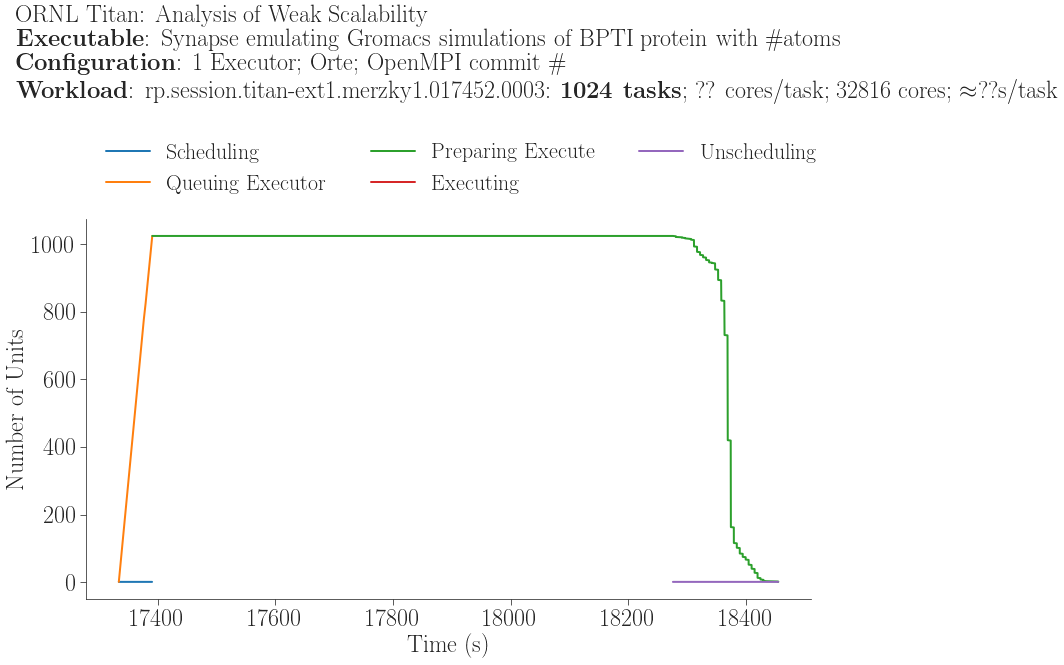

In [6]:
fig, ax = fig_setup()

title = '%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work)
fig.suptitle(title, x=0.05, y=1.3, horizontalalignment='left')

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])

# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'app_start'},                   # Execution start
 {ru.STATE: None, ru.EVENT: 'app_stop'}]   )                # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},            # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])            # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Executor', 'Preparing Execute', 
                  # 'Checking Directory', 'Spawning', 
                  'Executing', 'Unscheduling'])
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

Text(0,0.5,u'Time (s)')

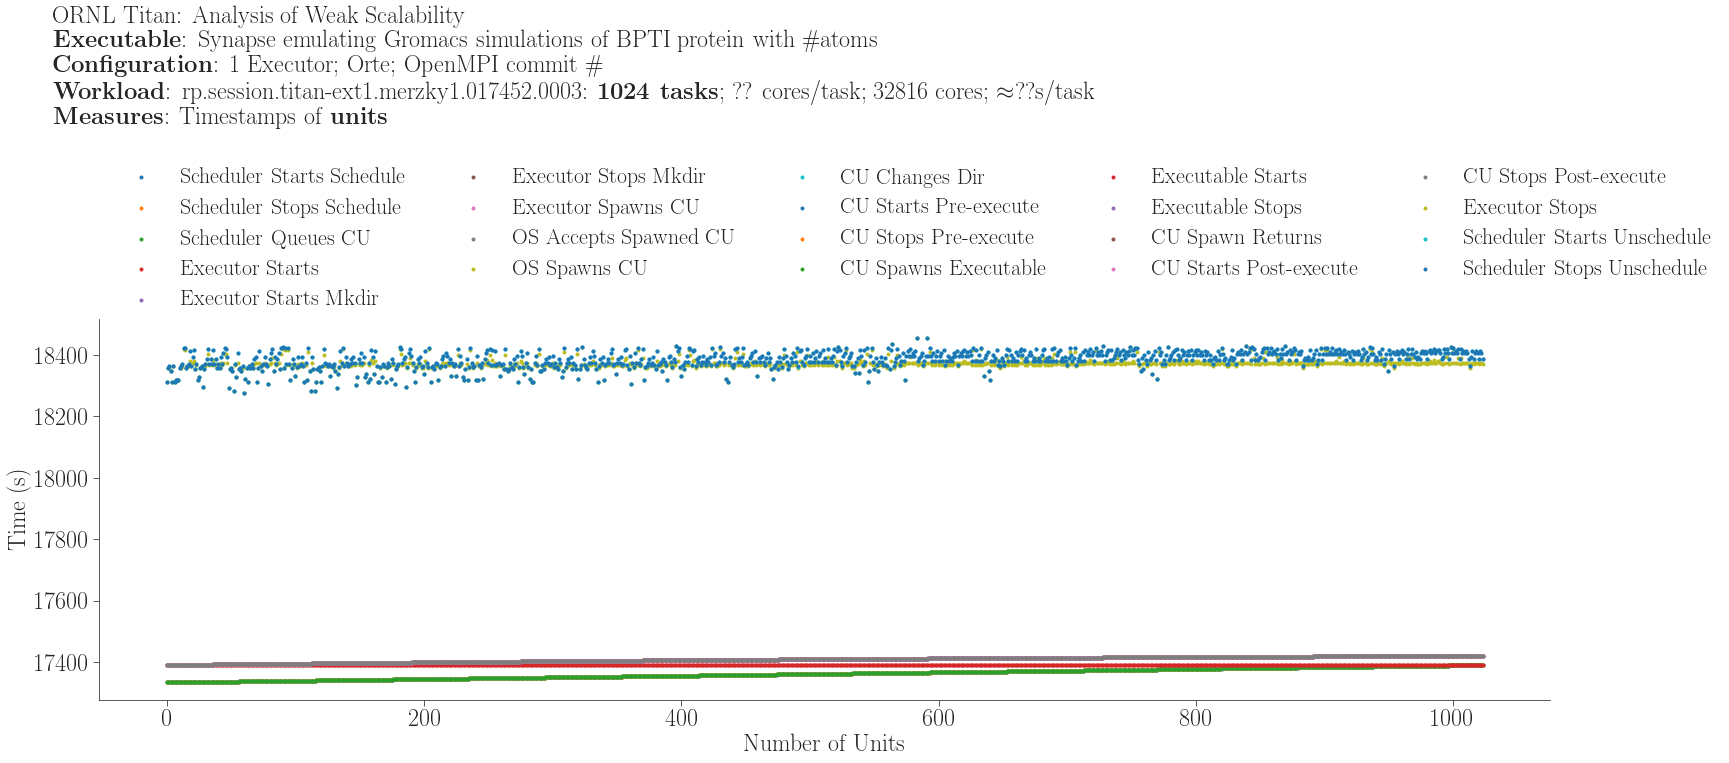

In [7]:
fig, ax  = fig_hdouble_setup()

title_desc = '\\textbf{Measures}: Timestamps of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.1, y=1.5, horizontalalignment='left')

plt.scatter(df['Scheduler Starts Schedule'].index  , df['Scheduler Starts Schedule']  , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Schedule'].index   , df['Scheduler Stops Schedule']   , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Queues CU'].index        , df['Scheduler Queues CU']        , marker='.') # Agent Scheduling Component
plt.scatter(df['Executor Starts'].index            , df['Executor Starts']            , marker='.') # Agent Executing Component
plt.scatter(df['Executor Starts Mkdir'].index      , df['Executor Starts Mkdir']      , marker='.') # Agent Executing Component
plt.scatter(df['Executor Stops Mkdir'].index       , df['Executor Stops Mkdir']       , marker='.') # Agent Executing Component
plt.scatter(df['Executor Spawns CU'].index         , df['Executor Spawns CU']         , marker='.') # Agent Executing Component
plt.scatter(df['OS Accepts Spawned CU'].index      , df['OS Accepts Spawned CU']      , marker='.') # System OS
plt.scatter(df['OS Spawns CU'].index               , df['OS Spawns CU']               , marker='.') # System OS
plt.scatter(df['CU Changes Dir'].index             , df['CU Changes Dir']             , marker='.') # CU script
plt.scatter(df['CU Starts Pre-execute'].index      , df['CU Starts Pre-execute']      , marker='.') # CU script
plt.scatter(df['CU Stops Pre-execute'].index       , df['CU Stops Pre-execute']       , marker='.') # CU script
plt.scatter(df['CU Spawns Executable'].index       , df['CU Spawns Executable']       , marker='.') # CU script [orterun spawner]
plt.scatter(df['Executable Starts'].index          , df['Executable Starts']          , marker='.') # Synapse
plt.scatter(df['Executable Stops'].index           , df['Executable Stops']           , marker='.') # Synapse, orterun [orterun spawner]
plt.scatter(df['CU Spawn Returns'].index           , df['CU Spawn Returns']           , marker='.') # CU script
plt.scatter(df['CU Starts Post-execute'].index     , df['CU Starts Post-execute']     , marker='.') # CU script
plt.scatter(df['CU Stops Post-execute'].index      , df['CU Stops Post-execute']      , marker='.') # CU script
plt.scatter(df['Executor Stops'].index             , df['Executor Stops']             , marker='.') # Agent Executing Component
plt.scatter(df['Scheduler Starts Unschedule'].index, df['Scheduler Starts Unschedule'], marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Unschedule'].index , df['Scheduler Stops Unschedule'] , marker='.') # Agent Scheduling Component


plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.45))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

#plt.savefig('figures/titan_synapse_strong_scaling_unit_events_16_full.pdf', dpi=300, bbox_inches='tight')